In [1]:
!pip install -U gensim

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spam_data = pd.read_csv('spam_home_kitchen.csv')
test_data = pd.read_csv('test_spam_home_kitchen.csv')

In [4]:
spam_data.head()

,Unnamed: 0,Processed Text,class
0,0,recommend great chef test cook cooking tool ea...,1.0
1,1,great pump work perfectly happy purchase thank...,1.0
2,2,beauty function saw pattern online corelle sco...,1.0
3,3,red neck wine glass wonderful use wedding toas...,1.0
4,4,stay away handle body make cheap plastic never...,0.0


In [5]:
class_0 = spam_data[spam_data['class']==0.]
print(len(spam_data))
print(len(class_0))
class_1 = spam_data[spam_data['class']==1.]
print(len(class_1))
class_1 = class_1.sample(n = len(class_0))
print(len(class_1))
class_1

13960
2865
11095
2865


,Unnamed: 0,Processed Text,class
11622,11622,work great hey funnel let get carry away fit f...,1.0
9328,9328,great sharpener never get good edge plain manu...,1.0
1484,1484,really cool mom huge doctor fan get poster fra...,1.0
2397,2397,go wrong lodge cast iron pleased find inch ski...,1.0
3700,3700,wash season over-trusted pre-seasoning dutch o...,1.0
...,...,...,...
8906,8906,stir long kinda thin feel well price paid happ...,1.0
7820,7820,like get much faster thought look nice item fi...,1.0
12796,12796,cook grill rock seriously farthest thing chef ...,1.0
1884,1884,really like pepper mill use william bound pepp...,1.0


In [6]:
reb_data = pd.concat((class_0,class_1)).reset_index(drop=True)

In [7]:
X_train = reb_data['Processed Text']
Y_train = reb_data['class']

In [8]:
class_0 = test_data[test_data['class']==0.]
class_1 = test_data[test_data['class']==1.]
class_1 = class_1.sample(n = len(class_0))

In [9]:
test_reb_data = pd.concat((class_0,class_1)).reset_index(drop=True)

In [10]:
X_test = test_reb_data['Processed Text']
Y_test = test_reb_data['class']

Word2Vec

In [11]:
words_in_sentences=[]
for i in tqdm(X_train):
    words_in_sentences.append(i.split())

100%|██████████████████████████████████████████████████████████████████████████| 5730/5730 [00:00<00:00, 139845.11it/s]


In [12]:
model = Word2Vec(sentences=words_in_sentences,vector_size = 300)

In [13]:
#Total number of words in the Vocabulary on which the Word2Vec model is trained.
vocab=list(model.wv.key_to_index.keys())
print(len(vocab))

3667


In [14]:
#Average Word2Vec is a technique in which the average of word embeddings of all the words given in a sentence is used as the numerical vector for a given sentence.
def avg_w2vec(sentences):
    transformed=[]
    for sentence in tqdm(sentences):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
        else:
            print(sentence)
    return np.array(transformed)

In [15]:
x_train_transformed=avg_w2vec(X_train)
x_test_transformed=avg_w2vec(X_test)

100%|████████████████████████████████████████████████████████████████████████████| 2502/2502 [00:02<00:00, 1020.97it/s]


In [16]:
#Using K-Nearest Neighbors Algorithm to predict whether a given review is Spam or not
grid_params = { 'n_neighbors' : [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80],
               'metric' : ['manhattan']}
knn=KNeighborsClassifier()
clf = RandomizedSearchCV(knn, grid_params, random_state=0,n_jobs=-1,verbose=1)
clf.fit(x_train_transformed,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['manhattan'],
                                        'n_neighbors': [5, 10, 15, 20, 25, 30,
                                                        35, 40, 45, 50, 55, 60,
                                                        65, 70, 75, 80]},
                   random_state=0, verbose=1)

In [17]:
clf.best_params_

{'n_neighbors': 55, 'metric': 'manhattan'}

In [18]:
clf.best_score_

0.6376963350785341

In [19]:
clf.cv_results_

{'mean_fit_time': array([0.02418685, 0.02538476, 0.02718439, 0.0267849 , 0.02658439,
        0.02598529, 0.02738433, 0.02738452, 0.02578473, 0.02778373]),
 'std_fit_time': array([0.00039971, 0.00079979, 0.00193776, 0.00171895, 0.00101946,
        0.00089378, 0.00162357, 0.00101899, 0.00074807, 0.00074848]),
 'mean_score_time': array([5.19002061, 5.19202056, 5.17083168, 5.19002004, 5.18782272,
        5.20321274, 5.14824481, 5.16483498, 5.12146068, 4.09524851]),
 'std_score_time': array([0.02040481, 0.03547597, 0.02646034, 0.01650721, 0.01752107,
        0.02582674, 0.02504896, 0.01141976, 0.02997269, 1.26095484]),
 'param_n_neighbors': masked_array(data=[10, 35, 45, 50, 70, 25, 15, 75, 55, 40],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manhattan', 'manhattan',
                    'manhattan', 'manhattan',

In [20]:
train_fpr,train_tpr,thresholds=roc_curve(Y_train,clf.predict_proba(x_train_transformed)[:,1])
test_fpr,test_tpr,thresholds=roc_curve(Y_test,clf.predict_proba(x_test_transformed)[:,1])

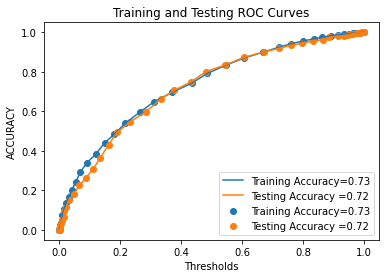

In [21]:

plt.plot(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.plot(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.scatter(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.scatter(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("ACCURACY")
plt.title("Training and Testing ROC Curves")
plt.show()

In [22]:
clf_pred = clf.predict(x_test_transformed)
cff_train_pred= clf.predict(x_train_transformed)

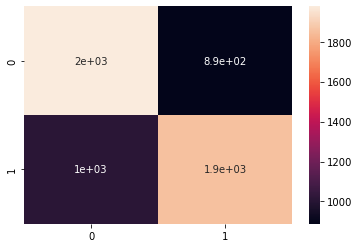

In [23]:
sns.heatmap(confusion_matrix(Y_train,cff_train_pred),annot=True)
plt.show()

In [24]:
print(classification_report(Y_train,cff_train_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.68      2865
         1.0       0.68      0.65      0.66      2865

    accuracy                           0.67      5730
   macro avg       0.67      0.67      0.67      5730
weighted avg       0.67      0.67      0.67      5730



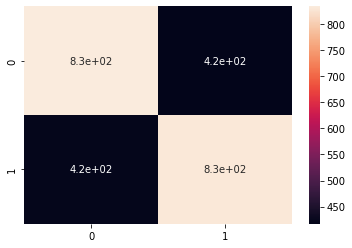

In [25]:
sns.heatmap(confusion_matrix(Y_test,clf_pred),annot=True)
plt.show()

In [26]:
print(classification_report(Y_test,clf_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.67      1251
         1.0       0.67      0.66      0.66      1251

    accuracy                           0.67      2502
   macro avg       0.67      0.67      0.67      2502
weighted avg       0.67      0.67      0.67      2502



In [28]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Accuracy score: ', format(accuracy_score(Y_test,clf_pred)))
print('Precision score: ', format(precision_score(Y_test,clf_pred)))
print('Recall score: ', format(recall_score(Y_test,clf_pred)))
print('F1 score: ', format(f1_score(Y_test,clf_pred)))

Accuracy score:  0.6650679456434853
Precision score:  0.6655974338412189
Recall score:  0.6634692246203038
F1 score:  0.6645316253002402


In [29]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svc = SVC(kernel = 'sigmoid', gamma = 1.0)
svc.fit(x_train_transformed, Y_train)

Y_pred = svc.predict(x_test_transformed)
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Accuracy score: ', format(accuracy_score(Y_pred,Y_test )))
print('Precision score: ', format(precision_score(Y_test,Y_pred)))
print('Recall score: ', format(recall_score(Y_test, Y_pred)))
print('F1 score: ', format(f1_score(Y_test, Y_pred)))

Accuracy score:  0.5375699440447642
Precision score:  0.5226396917148363
Recall score:  0.8673061550759392
F1 score:  0.6522392545837091


In [30]:
#Import the DecisionTreeeClassifier
from sklearn.tree import DecisionTreeClassifier
#Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()
clf_decision_word2vec.fit(x_train_transformed, Y_train)
Y_pred2 = clf_decision_word2vec.predict(x_test_transformed)
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Accuracy score: ', format(accuracy_score(Y_pred2,Y_test )))
print('Precision score: ', format(precision_score(Y_test,Y_pred2)))
print('Recall score: ', format(recall_score(Y_test, Y_pred2)))
print('F1 score: ', format(f1_score(Y_test, Y_pred2)))

Accuracy score:  0.6111111111111112
Precision score:  0.6082554517133957
Recall score:  0.6243005595523581
F1 score:  0.6161735700197238


In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
lr = LogisticRegression()
lr.fit(x_train_transformed, Y_train)
lrpredicted = lr.predict(x_test_transformed)

In [33]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
lr_accuracy = accuracy_score(lrpredicted,Y_test )
print('Accuracy score: ', format(accuracy_score(lrpredicted,Y_test )))
print('Precision score: ', format(precision_score(Y_test,lrpredicted)))
print('Recall score: ', format(recall_score(Y_test, lrpredicted)))
print('F1 score: ', format(f1_score(Y_test, lrpredicted)))

Accuracy score:  0.7086330935251799
Precision score:  0.7277486910994765
Recall score:  0.6666666666666666
F1 score:  0.6958698372966208
